In [1]:
!which python

/c/Users/frant/PycharmProjects/jupyterNotebook/venv/Scripts/python


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
prices = pd.read_csv("../data/closes.csv")

In [4]:
prices["Date"] = pd.to_datetime(prices["Date"], infer_datetime_format = True)

In [5]:
prices["Year"] = prices["Date"].apply(lambda d: d.year)
prices["Month"] = prices["Date"].apply(lambda d: d.month)
prices["Day"] = prices["Date"].apply(lambda d: d.day)
prices["Semester"] = prices["Month"].apply(lambda m: 1 if 1<=m<=6 else 2)

In [6]:
prices.groupby([prices.Year, prices.Semester]).count()

Date  AGRO.BA  ALUA.BA  AUSO.BA  BBAR.BA  BHIP.BA  BMA.BA  \
Year Semester                                                              
2011 1          120      120      120      119      120      120     120   
     2          124      124      124      124      124      124     124   
2012 1          119      119      119      119      119      119     119   
     2          123      123      123      123      123      123     123   
2013 1          118      118      118      118      118      118     118   
     2          124      124      124      124      124      124     124   
2014 1          124      124      124      124      124      124     124   
     2          126      124      124      124      124      124     124   
2015 1          120      120      120      120      120      120     120   
     2          122      122      122      122      122      122     122   
2016 1          123      122      122      122      122      122     122   
     2          125      125      125      125      125      125     125   
2017 1          122      122      122      122      122      122     122   
     2          121      121      121      121      121      121     121   
2018 1          121      121      121      121      121      121     121   
     2          124      124      124      124      124      124     124   
2019 1          120      120      120      120      120      120     120   
     2          124      124      124      124      124      124     124   
2020 1          119      119      119      119      119      119     119   
     2          122      122      122      122      122      122     122   
2021 1           38       38       38       38       38       38      38   

               BOLT.BA  BPAT.BA  BRIO.BA  ...  TGLT.BA  TGNO4.BA  TGSU2.BA  \
Year Semester                             ...                                
2011 1             120      120      120  ...      120       120       120   
     2             124      124      124  ...      124       124       124   
2012 1             119      119      119  ...      119       119       119   
     2             123      123      123  ...      123       123       123   
2013 1             118      118      118  ...      118       118       118   
     2             124      124      124  ...      124       124       124   
2014 1             124      124      124  ...      124       124       124   
     2             124      124      124  ...      124       124       124   
2015 1             120      120      120  ...      120       120       120   
     2             122      122      122  ...      122       122       122   
2016 1             122      122      122  ...      122       122       122   
     2             125      125      125  ...      125       125       125   
2017 1             122      122      122  ...      122       122       122   
     2             121      121      121  ...      121       121       121   
2018 1             121      121      121  ...      121       121       121   
     2             124      124      124  ...      124       124       124   
2019 1             120      120      120  ...      120       120       120   
     2             124      124      124  ...      124       124       124   
2020 1             119      119      119  ...      119       119       119   
     2             122      122      122  ...      122       122       122   
2021 1              38       38       38  ...       38        38        38   

               TRAN.BA  TXAR.BA  VALO.BA  YPFD.BA  ^MERV  Month  Day  
Year Semester                                                         
2011 1             120      120      120      120    120    120  120  
     2             124      124      124      124    123    124  124  
2012 1             119      119      119      119    119    119  119  
     2             123      123      123      123    122    123  123  
2013 1             118      118      118     

## Everything with the first window, next loop over windows

In [7]:
grouped = prices.groupby([prices.Year, prices.Semester])

In [8]:
start_year = 2011
end_year = 2014
semester = 1

 #### Training set consists in 4 years and the testing set in the next semester

In [9]:
training_set = pd.concat( 
    [ grouped.get_group( (year, semester) ) 
     for year in range(start_year, end_year + 1)
     for semester in (1,2)],
     axis =0)
testing_year = end_year + 1 if semester == 1 else end_year
test_set = grouped.get_group( (testing_year, semester))

In [10]:
training_set.set_index("Date", inplace=True)
test_set.set_index("Date", inplace=True)

In [11]:
training_set.shape, test_set.shape

((978, 76), (120, 76))

Let's see if everything is ok

In [12]:
training_set.groupby([training_set.Year, training_set.Semester])["Month"].count()

Year  Semester
2011  1           120
      2           124
2012  1           119
      2           123
2013  1           118
      2           124
2014  1           124
      2           126
Name: Month, dtype: int64

In [13]:
test_set.groupby([test_set.Year, test_set.Semester])["Month"].count()

Year  Semester
2015  1           120
Name: Month, dtype: int64

Clean all tickers that have less than 80% of the data

In [14]:
ticker_amounts =  training_set.drop(["Year", "Month", "Day", "Semester", "^MERV"], axis=1).count()

max_obs = ticker_amounts.nlargest().iloc[0]

tickers_to_keep = ticker_amounts[ ticker_amounts >= int( 0.8 * max_obs) ].index.to_list()

len(tickers_to_keep)

62

In [15]:
training_set = training_set.loc[ :, tickers_to_keep ]

Remove tickers that are empty at the beginning or the end

In [16]:
empty_at_first = training_set.head(5).agg(lambda s : all(s.isna()))
empty_at_last = training_set.tail(5).agg(lambda s : all(s.isna()))

In [17]:
other_removal = empty_at_last[empty_at_last == True].index.to_list() + empty_at_first[empty_at_first == True].index.to_list()

In [18]:
training_set.drop(other_removal, axis = 1, inplace = True)

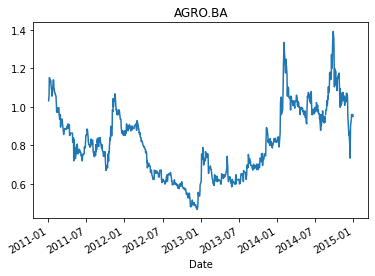

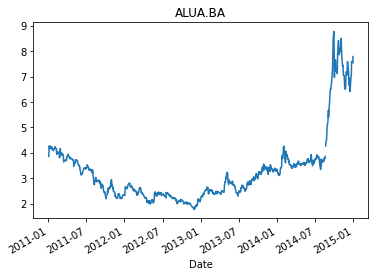

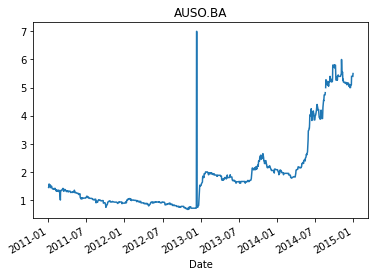

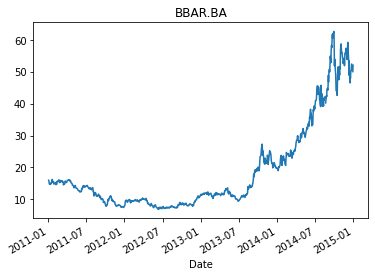

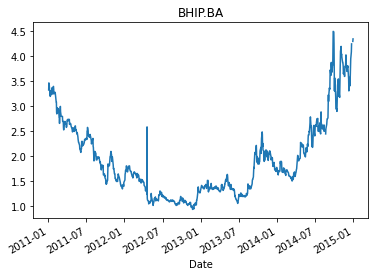

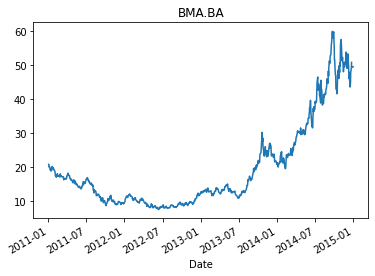

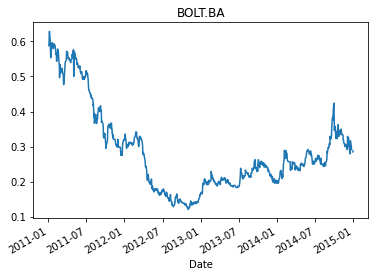

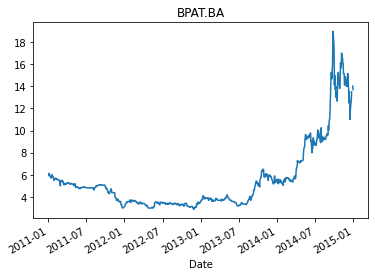

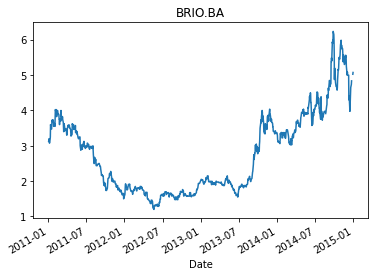

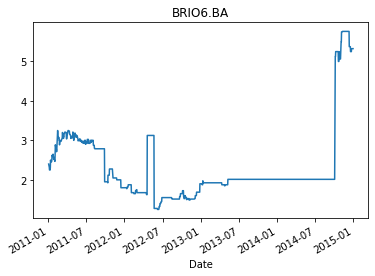

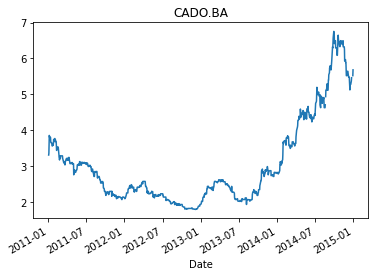

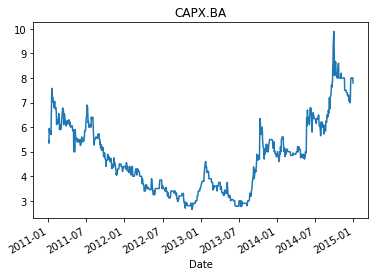

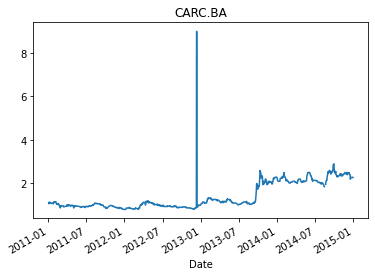

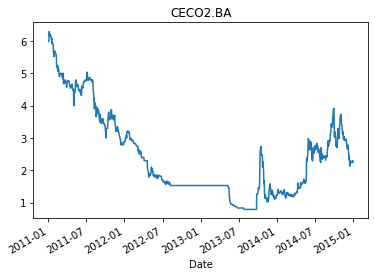

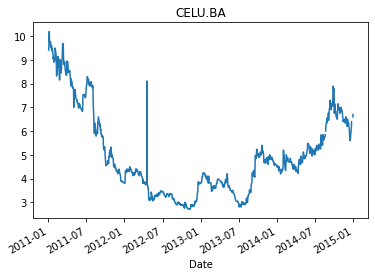

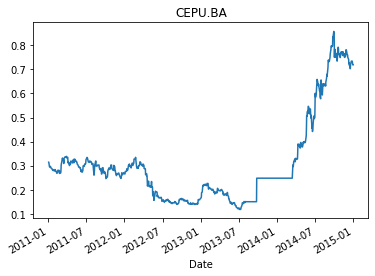

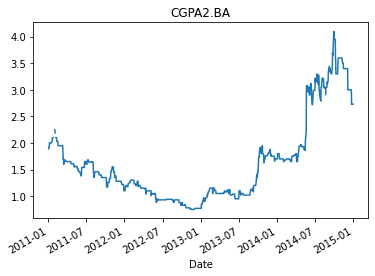

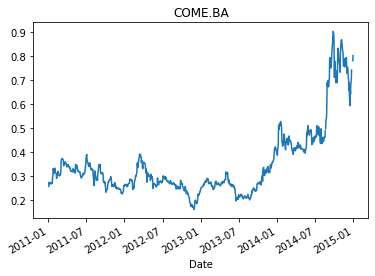

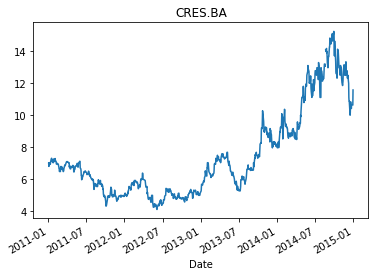

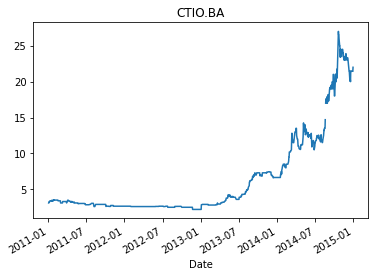

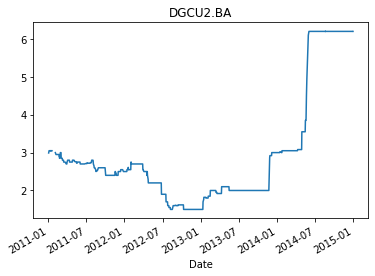

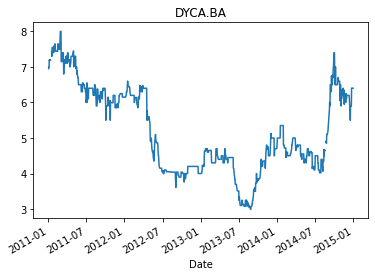

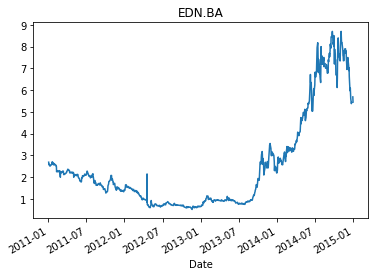

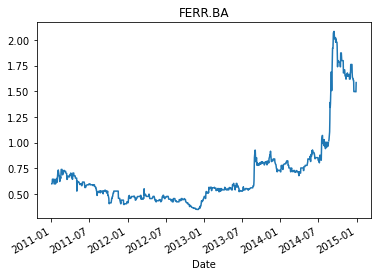

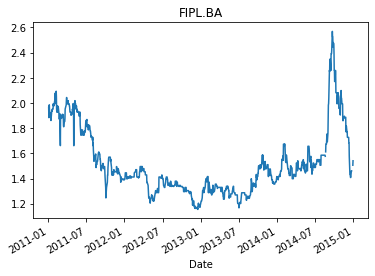

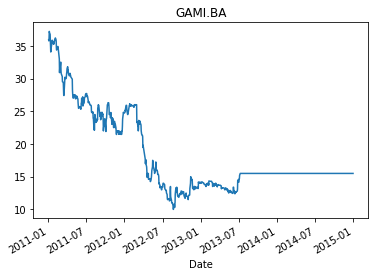

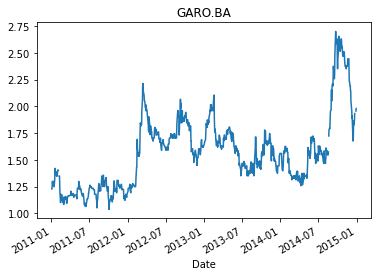

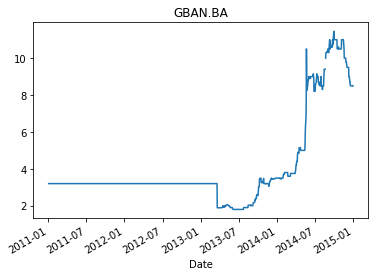

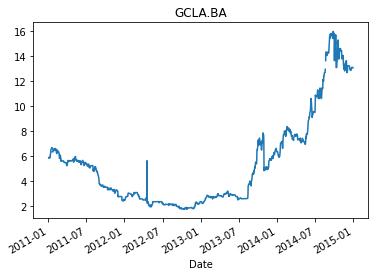

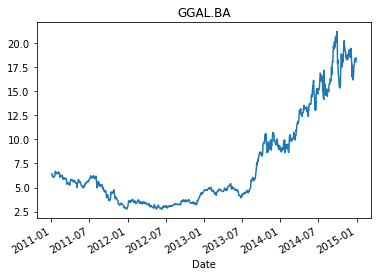

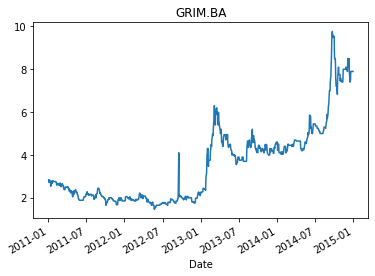

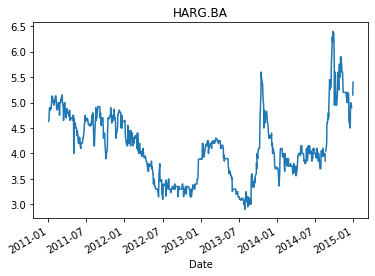

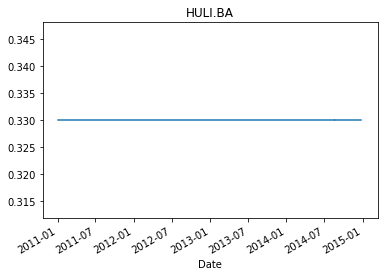

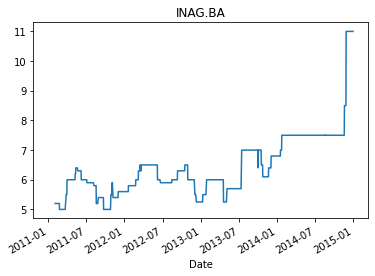

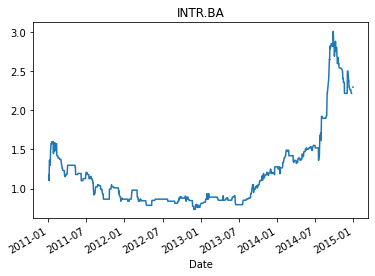

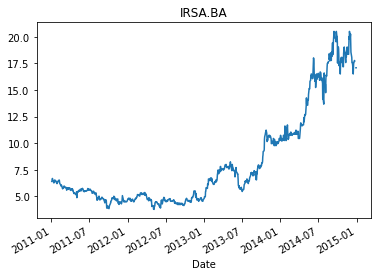

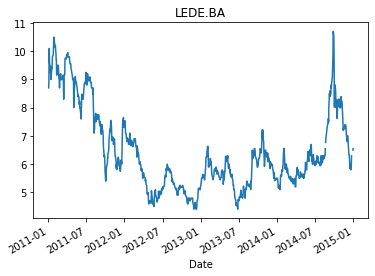

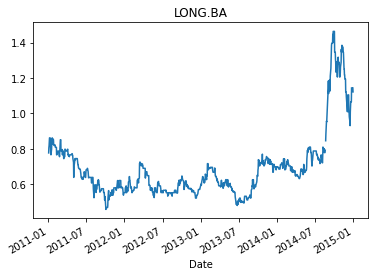

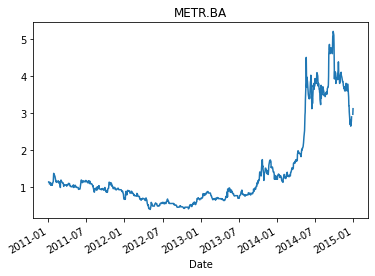

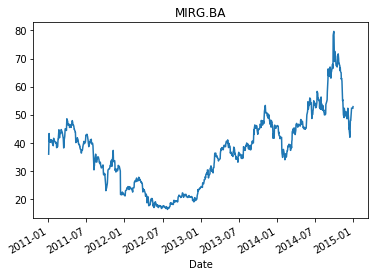

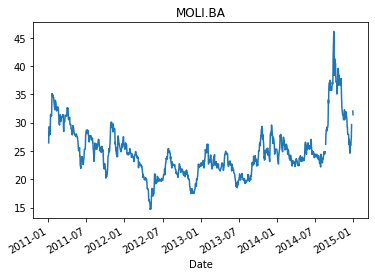

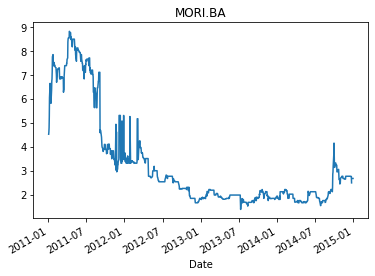

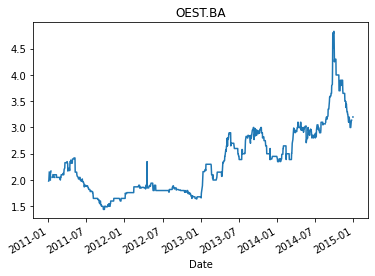

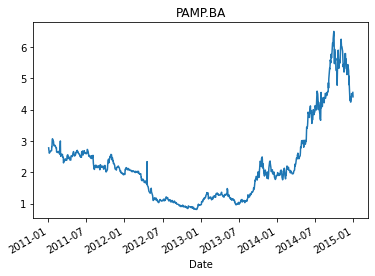

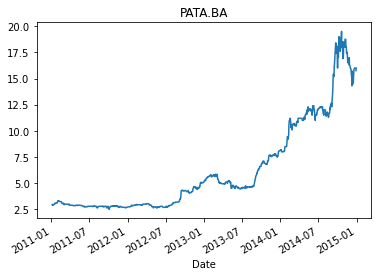

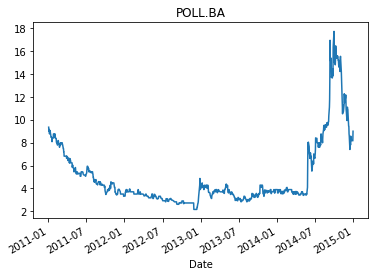

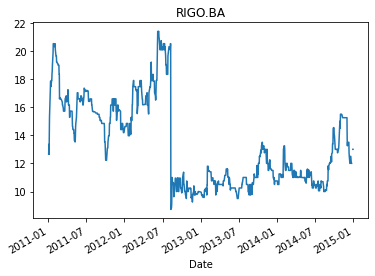

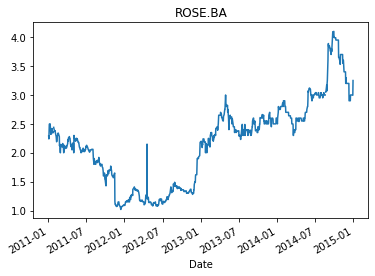

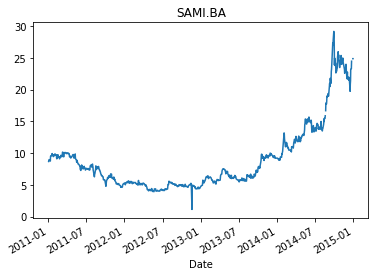

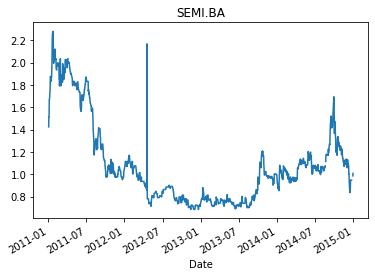

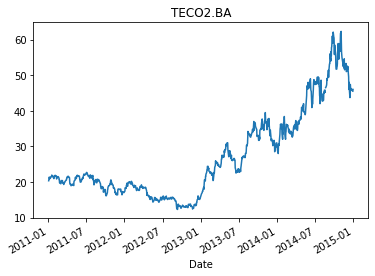

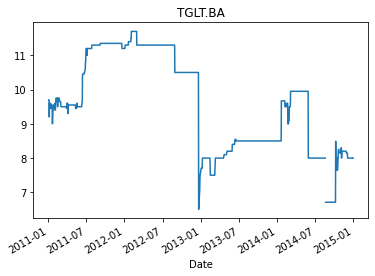

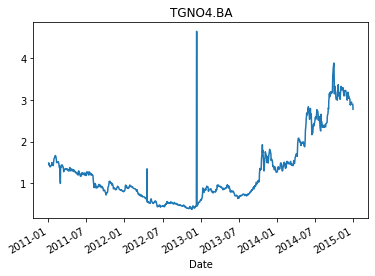

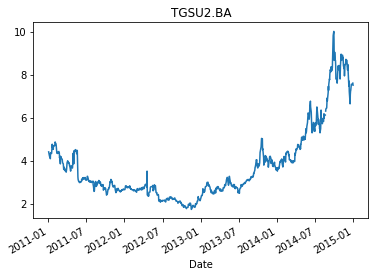

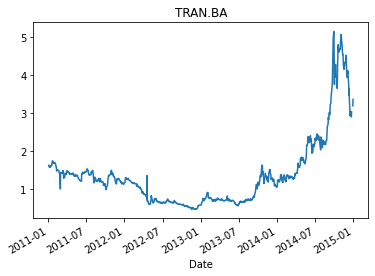

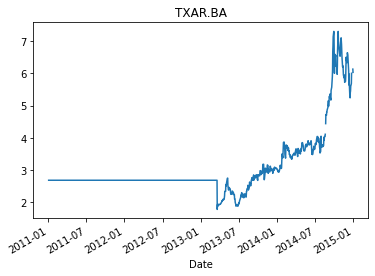

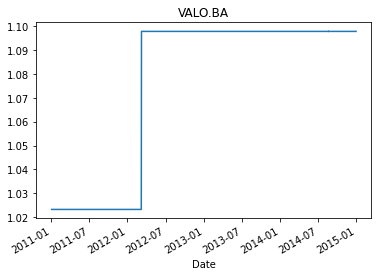

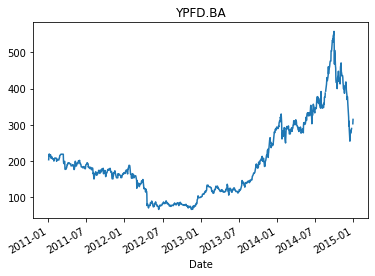

In [19]:
for ser in training_set.columns:
    training_set[ser].plot(title = ser)
    plt.show()

## Clean the outliers!

Now fill the missing data

In [20]:
training_set = training_set.fillna(training_set.rolling(int(0.2 * max_obs), min_periods=1).mean())

In [21]:
assert not training_set.isnull().values.any()

In [22]:
training_set.shape

(978, 58)

Now let's prepare the data for the autoencoder:
- convert prices into returns
- scaling